## Modelling Leaf Localization
This notebook runs through our code for building a model that performs object localization on the leaf images, to identify the location of the leaf in an image.

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

### Loading in the training images

In [3]:
train = pd.read_csv("plant-pathology-2020-fgvc7/train_bbox.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image_id  500 non-null    object 
 1   x0        500 non-null    float64
 2   y0        500 non-null    float64
 3   width     500 non-null    float64
 4   height    500 non-null    float64
dtypes: float64(4), object(1)
memory usage: 19.7+ KB


In [4]:
train_images = []
 
IMG_WIDTH = 200
IMG_HEIGHT = 150
for image_name in train['image_id']: 
    path = "plant-pathology-2020-fgvc7/images/" + image_name + ".jpg"
    image = cv2.imread(path)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT),interpolation=cv2.INTER_AREA)
    train_images.append(image)

x = np.array(train_images)
x = x / 255

In [5]:
y = train.drop(columns='image_id')
y.head()

x0        y0     width    height
0  0.050781  0.153846  0.735840  0.705495
1  0.092773  0.142125  0.719727  0.745055
2  0.156738  0.221978  0.843262  0.622711
3  0.012207  0.167033  0.888672  0.555311
4  0.067871  0.322344  0.932129  0.381685

### Splitting into training and validation set

In [6]:
y = y.to_numpy()

x_train = x[0:400]
y_train = y[0:400]
x_valid = x[400:500]
y_valid = y[400:500]

### Custom callback method for early stopping

In [28]:
class IouCallback(keras.callbacks.Callback):
    """
    Custom callback method used during training for early stopping. 
    The model will stop training when the mean IoU, and validation 
    mean IoU threshold have been met or exceeded.
    
    """
    def __init__(self, iou_threshold, val_iou_threshold):
        super(IouCallback, self).__init__()
        self.iou_threshold = iou_threshold
        self.val_iou_threshold = val_iou_threshold

    def on_epoch_end(self, epoch, logs=None): 
        if logs["mean_iou"] >= self.iou_threshold and logs["val_mean_iou"] >= self.val_iou_threshold:
            self.model.stop_training = True

### Custom metric function for IoU

In [7]:
def calculate_iou(pred_bbox, true_bbox):
    """
    Calculates the Intersection over Union (IoU) score between
    the predicted and true bounding box provided.
    """
    
    pred_x0 = pred_bbox[0]
    pred_y0 = pred_bbox[1]
    pred_x1 = pred_x0 + pred_bbox[2]
    pred_y1 = pred_y0 + pred_bbox[3]

    true_x0 = true_bbox[0]
    true_y0 = true_bbox[1]
    true_x1 = true_x0 + true_bbox[2]
    true_y1 = true_y0 + true_bbox[3]

    x_left = max(pred_x0, true_x0)
    y_top = max(pred_y0, true_y0)
    x_right = min(pred_x1, true_x1)
    y_bottom = min(pred_y1, true_y1)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    pred_bbox_area = (pred_x1 - pred_x0) * (pred_y1 - pred_y0)
    true_bbox_area = (true_x1 - true_x0) * (true_y1 - true_y0)

    iou = intersection_area / (pred_bbox_area + true_bbox_area - intersection_area)
    return iou


In [8]:
def mean_iou(y_true, y_pred):
    """
    Calculates the mean Intersection over Union (IoU) score 
    between all predicted and true bounding boxes provided.
    """
    try: # Incase input are tensors
        y_true = y_true.numpy() 
        y_pred = y_pred.numpy()
    except:
        pass

    ious = np.array([])

    for i in range(len(y_true)):
        ious = np.append(ious, calculate_iou(y_pred[i], y_true[i]))

    return np.mean(ious)

### Model Definition

In [33]:
model = Sequential()

model.add(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(150, 200, 3), kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (5,5), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding='same'))

model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding='same'))

model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding='same'))

model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding='same'))

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=4, activation='sigmoid'))

rmsprop = keras.optimizers.RMSprop(learning_rate=0.0005)
model.compile(optimizer = rmsprop, loss = 'mean_squared_error', metrics = [mean_iou], run_eagerly = True)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 150, 200, 32)      2432      
_________________________________________________________________
batch_normalization_77 (Batc (None, 150, 200, 32)      128       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 150, 200, 128)     102528    
_________________________________________________________________
batch_normalization_78 (Batc (None, 150, 200, 128)     512       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 75, 100, 128)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 75, 100, 32)       36896     
_________________________________________________________________
batch_normalization_79 (Batc (None, 75, 100, 32)      

### Model Training

In [34]:
training_history = model.fit(x = x_train, y = y_train, batch_size = 32, epochs = 1000, validation_data = (x_valid, y_valid), callbacks = [IouCallback(0.85, 0.79)])

Epoch 1/1000
13/13 [==============================] - 3s 229ms/step - loss: 0.1862 - mean_iou: 0.1226 - val_loss: 0.1273 - val_mean_iou: 0.2701
Epoch 2/1000
13/13 [==============================] - 3s 227ms/step - loss: 0.1698 - mean_iou: 0.1629 - val_loss: 0.1218 - val_mean_iou: 0.2910
Epoch 3/1000
13/13 [==============================] - 3s 217ms/step - loss: 0.1555 - mean_iou: 0.1845 - val_loss: 0.1079 - val_mean_iou: 0.4015
Epoch 4/1000
13/13 [==============================] - 3s 216ms/step - loss: 0.1405 - mean_iou: 0.2422 - val_loss: 0.1001 - val_mean_iou: 0.4109
Epoch 5/1000
13/13 [==============================] - 3s 223ms/step - loss: 0.1303 - mean_iou: 0.2653 - val_loss: 0.0620 - val_mean_iou: 0.5191
Epoch 6/1000
13/13 [==============================] - 3s 217ms/step - loss: 0.1217 - mean_iou: 0.3087 - val_loss: 0.0546 - val_mean_iou: 0.6592
Epoch 7/1000
13/13 [==============================] - 3s 222ms/step - loss: 0.1111 - mean_iou: 0.3432 - val_loss: 0.0491 - val_mean_iou:

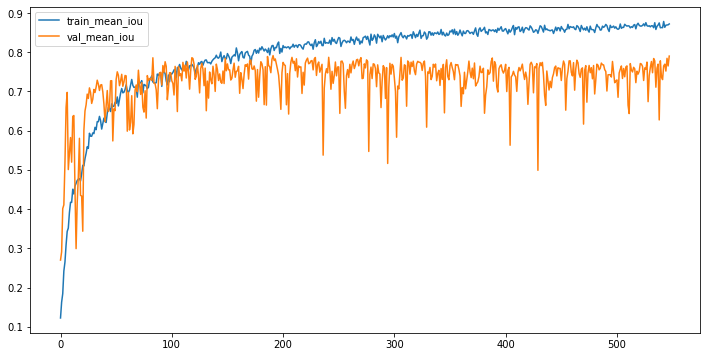

In [36]:
plt.figure(figsize = (12, 6))
plt.plot(training_history.history["mean_iou"], label = "train_mean_iou")
plt.plot(training_history.history["val_mean_iou"], label = "val_mean_iou")
plt.legend()

### Model Evaluation on Training and Validation Images

In [37]:
y_pred = model.predict(x_train)

In [38]:
print(f"Training Mean IoU: {mean_iou(y_train, y_pred)}")

Training Mean IoU: 0.9293252709428405


In [39]:
def plot_bboxes(images, y_pred, lower, upper, y_true=None):
    fig, ax = plt.subplots(1, upper - lower, figsize=(20, 6))

    for i in range(lower, upper):

    image_copy = images[i].copy()

    if y_true is not None:
        x0 = int(y_true[i][0] * IMG_WIDTH) 
        y0 = int(y_true[i][1] * IMG_HEIGHT)
        x1 = int((y_true[i][0] + y_true[i][2]) * IMG_WIDTH)
        y1 = int((y_true[i][1] + y_true[i][3]) * IMG_HEIGHT)

        image_copy = cv2.rectangle(image_copy, (x0, y0), (x1, y1), (0, 255, 0), 2)
        iou = round(calculate_iou(y_pred[i], y_true[i]), 3)
        ax[i - lower].set_title(f"IoU: {iou}")

    x0 = int(y_pred[i][0] * IMG_WIDTH)
    y0 = int(y_pred[i][1] * IMG_HEIGHT)
    x1 = int((y_pred[i][0] + y_pred[i][2]) * IMG_WIDTH)
    y1 = int((y_pred[i][1] + y_pred[i][3]) * IMG_HEIGHT)

    image_copy = cv2.rectangle(image_copy, (x0, y0), (x1, y1), (255, 0, 0), 2)

    ax[i - lower].set_axis_off()
    ax[i - lower].imshow(image_copy) 

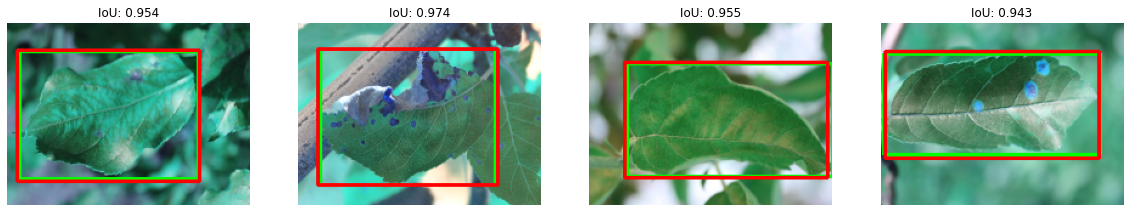

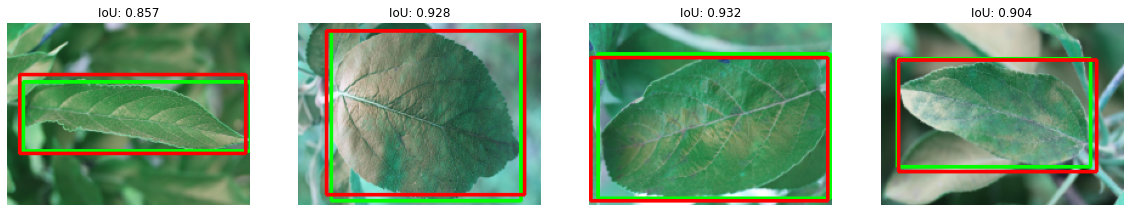

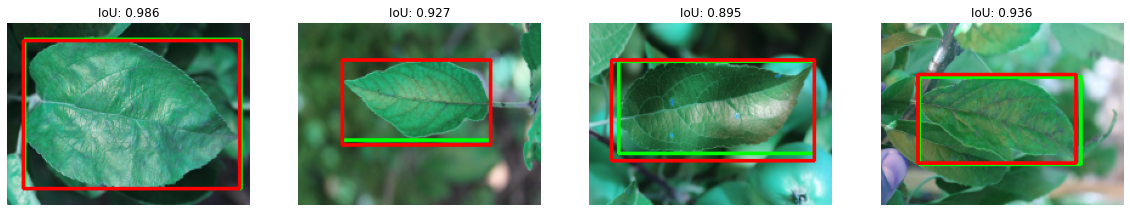

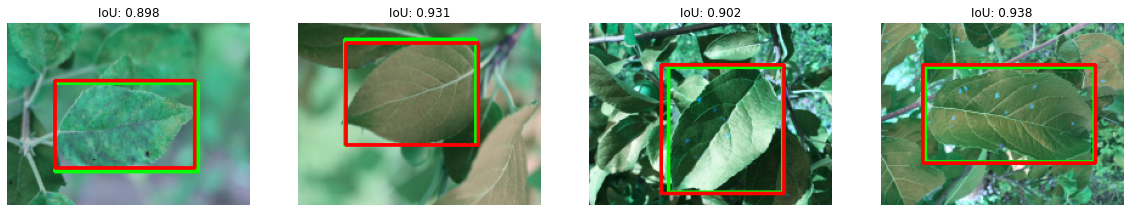

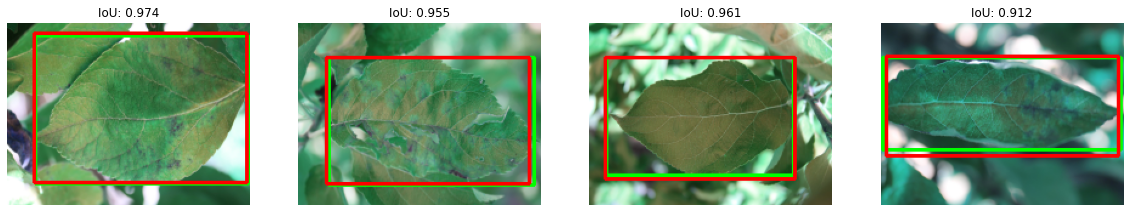

In [40]:
for i in range(0, 20, 4):
  plot_bboxes(train_images[0:400], y_pred, i, i+4, y_train)

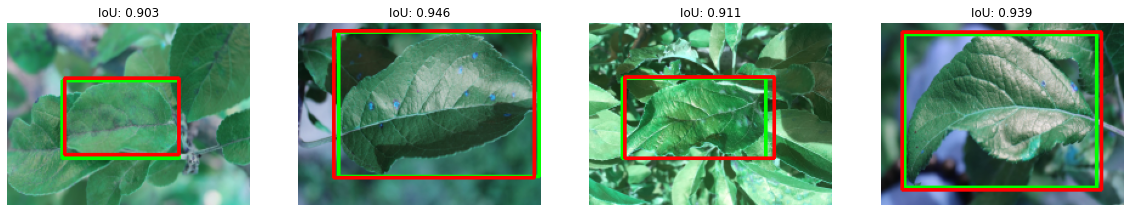

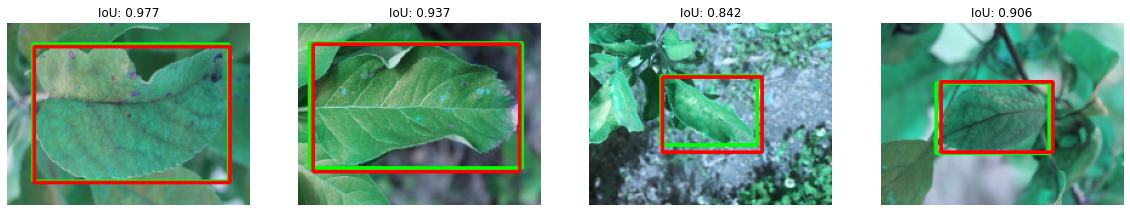

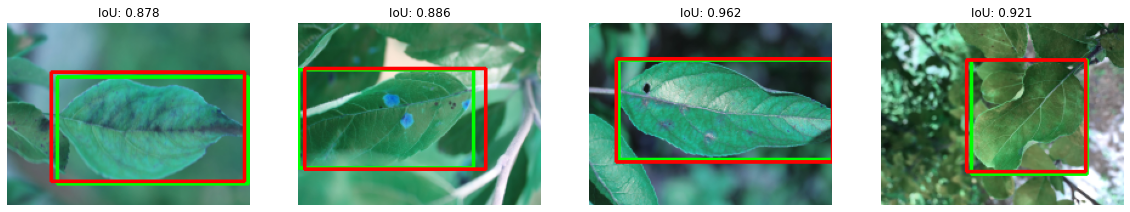

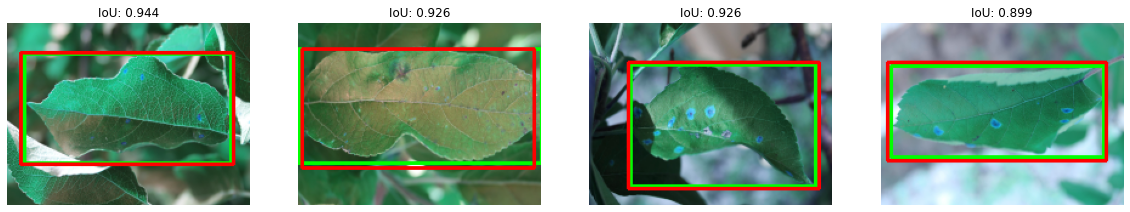

In [41]:
for i in range(20, 40, 5):
  plot_bboxes(train_images[0:400], y_pred, i, i+4, y_train)

In [42]:
y_pred = model.predict(x_valid)

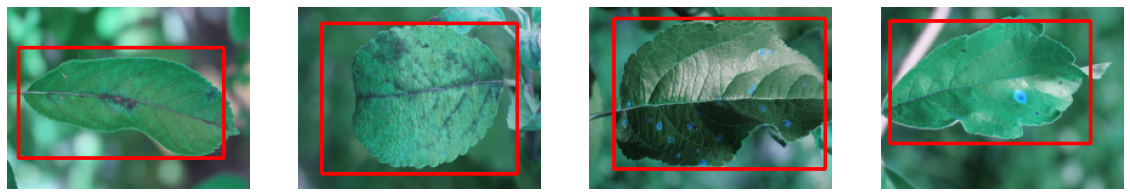

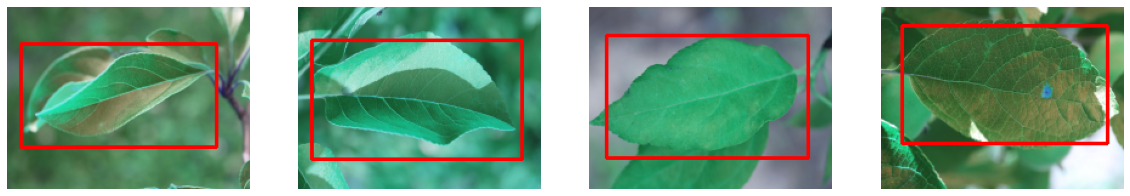

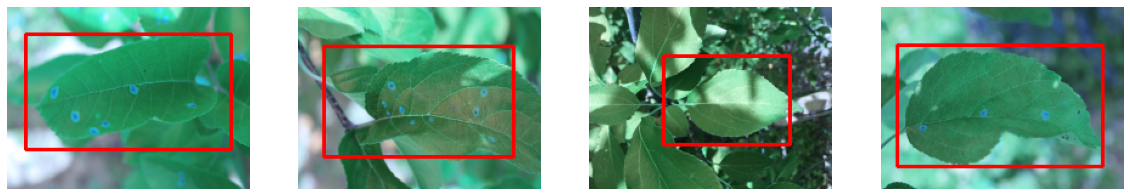

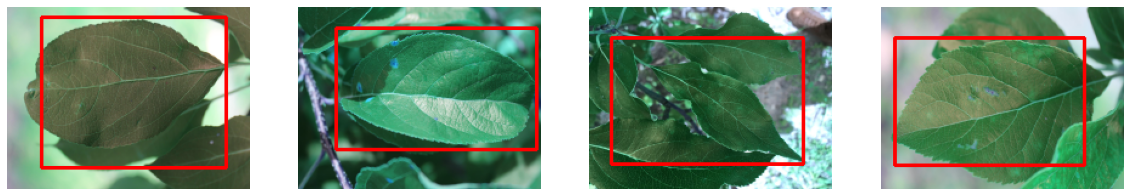

In [43]:
for i in range(0, 20, 5):
  plot_bboxes(train_images[400:500], y_pred, i, i+4)

In [44]:
model.save("model_bbox.h5")

In [45]:
handler = open("training_history_bbox.pickle", "wb")
pickle.dump(training_history.history, handler)